# Random ODE Generator

## Setting Problem Up

In [ ]:
### Imports ###

import numpy as np
from sympy import *
import random as rand
import IPython.display as disp
init_printing()

In [ ]:
### Setting predetermined values ###

# Setting the order of the equation (fixed)
n = 3

########

# Number of y-type terms (x, y, y', etc.)
T = n + 2

# Minimum number of subterms total (total number of terms in the final equation)
min_subterms = 3

# Maximum number of subterms total (total number of terms in the final equation)
max_subterms = 5

# Maximum number of times a function recursively called to create a function
max_fun = 2

# Sets the cumulative probabilities for the following function types:
# (1) No change (2) power (3) exponential (4) logarithmic (5) trig (6) hyperbolic
function_cdf = [0.1, 0.5, 0.62, 0.74, 1, 1]

# Sets the probability that the function creating function will recursively call
# itself again
recurs_prob = 0.1

# The probability of adding a constant to the function
add_c_prob = 0.2

In [ ]:
### Defining the symbols, functions, and terms ###

# Define symbol and function variables
x = Symbol('x')

# Stores the y-type terms (x, y, y', etc.) in an array called y_terms
y_terms = np.empty(T, dtype=Symbol)
y_terms[0] = x

for i in range(1, T):
    #y_terms[i] = y(x).diff(x, i - 1)
    y_terms[i] = Symbol('y'+str(i-1))

## Functions

In [ ]:
def num_subterms (sum_min, sum_max):
    '''
    This creates an array of the number of subterms for each y-type term.
    If the number of subterms is less than the specified minimum or greater than
    the specified maximum, the function will call itself recursively until
    a valid number of subterms are determined.

    Parameters
    ----------
    sum_min:  int
              The minimum number of total subterms
    sum_max:  int
              The maximum number of total subterms

    Returns
    ----------
    temp: numpy array of int
          Returns the number of subterms for each y-type term
    '''

    temp = np.empty(T, dtype=int)
    # Initially set that the nth derivative term has one subterm
    temp[-1] = 1

    # Set number of subterms (0, 1, or 2) for remaining terms
    for i in range(T - 1):
        # Sets the probability of having 0 subterms, 1 subterm, 2 subterms
        probabilities = [0] * 1 + [1] * 5 + [2] * 1
        temp[i] = rand.choice(probabilities)

    if (sum(temp) < sum_min or sum_min > sum_max):
        return num_subterms (sum_min, sum_max)
    return temp

In [ ]:
def create_subterms (y_term, num_sub):
    '''
    This returns all subterms of the equation.

    Parameters
    ----------
    y_term:   numpy array of Object
              The y-type terms (x, y, y', etc.)
    num_sub:  numpy array of int
              The number of subterms for each y-type term

    Returns
    ----------
    subterms: numpy array of Object
              Returns all of the subterms for the equation
    '''

    # Stores the subterms
    subterms = np.empty(sum(num_sub), dtype=Mul)

    # Keeps track of index of subterms we are at
    counter = 0;

    for i, y_t in enumerate(y_term):
        for n_s in range(num_sub[i]):
            # Determines function to be applied to the y_term
            subterms[counter] = create_subterm(y_t, function_cdf, 1, max_fun, add_c_prob)
            counter += 1

    return subterms

In [ ]:
def create_subterm (y_term, cdf, iteration, max_it, const_prob):
    '''
    This returns a random subterm (a random function of the given y_term).
    It may recursively call itself to make a more complicated funciton up to
    max_it times.

    The drawable functions include power, exponential, logarithmic,
    trigonometric, and hyperbolic.

    Parameters
    ----------
    y_term:     Object
                The y-type term (x, y, y', etc.)
    cdf:        int
                The cumulative pobability of each function type (power,
                exponential, logarithmic, trigonometric, and hyperbolic)
    iteration:  int
                The iteration number (how many times the function has
                been called)
    max_it:     int
                The maximum number of times the function can be called
    const_prob: float
                The probability of adding a constant to the current subterm

    Returns
    ----------
    subterm:  Object
              Returns a subterm for a function of a given y_term
    '''

    # Default value (function does nothing)
    subterm = y_term

    # RETURNING y3 alone
    if subterm == y3:
      return y3

    # Randomly determines if a function must be applied (and which function)
    temp = rand.random()

    # Hyperbolic
    #if temp > cdf[4]:
    #    hyp_fun = [sinh(y_term+1)] + [cosh(y_term+1)] + [tanh(y_term+1)]
    #    subterm = rand.choice(hyp_fun)
    # Trig
    #elif
    if temp > cdf[3]:
        trig_fun = [sin(y_term+1)] + [cos(y_term+1)] + [tan(y_term+1)]
        subterm = rand.choice(trig_fun)
    # Log
    elif temp > cdf[2]:
        subterm = log(y_term+1)
    # Exponential
    elif temp > cdf[1]:
        subterm = exp(y_term)
    # Power
    elif temp > cdf[0]:
        # Random power from 1 to 10
        fun_power = rand.randint(1, 10)

        # Will turn power negative 20% of the time
        if rand.random() < 0.2:
            fun_power *= -1

        # Will turn the power into 1/power 20% of the time
        if rand.random() < 0.2:
            subterm = y_term**(1/fun_power)
        else:
            subterm = (y_term)**(fun_power)

    # Determines coefficient
    coeffs = np.linspace(-11,-1,11, dtype=int)+np.linspace(1,11,11, dtype=int)
    if rand.random() < 0.3:
        subterm *= rand.choice(coeffs)
    elif rand.random() > 0.8:
        subterm /= rand.choice(coeffs)

    # Determines added constant
    if rand.random() < const_prob:
        subterm += rand.choice(coeffs)

    if subterm == 0:
        return create_subterm(y_term, cdf, iteration, max_it, const_prob)

    # Will consider reiterating if we have not yet reached the maximum
    # number of iterations
    if iteration < max_it:
        # If so, will add another function on top of this one
        if rand.random() < recurs_prob:
            # Recursively calls its own function to
            # create a more complicated function
            subterm = create_subterm(subterm, cdf, iteration + 1, max_it, const_prob)
        # If not, will randomly determine if some additional p(x) should be added
        elif rand.random() < 0.4:
            # Only p(x)
            # subterm *= create_subterm(x, cdf, max_it, max_it, 0)

            # OR, anything with lower y-like term than current
            possible_subterms = [x]
            for i in y_terms:
                if i == y_term:
                    break
                possible_subterms += [i]
            subterm *= create_subterm(rand.choice(possible_subterms), cdf, max_it, max_it, 0)

    return simplify(subterm)

## Final Calculation and Output

In [ ]:
terms = create_subterms(y_terms, num_subterms(min_subterms, max_subterms))
print("The terms are:")
for i in range(len(terms)):
    disp.display(terms[i])
    print()

NameError: ignored

In [ ]:
sum(terms)

In [ ]:
solve(sum(terms),y3)

# Dominant Balance Solver

## All helper functions for solver


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from sympy import *
init_printing()
from sympy.utilities.lambdify import lambdify, implemented_function

In [ ]:
# SOLVER (depending on which order it is, we would have to use different fun)
# the following is an example for third order

# define a function to convert sympy to numpy functions
def sym_convert(eq):
  return lambdify([y0,y1,y2,y3,x], eq)

# here, we define the compiled solver
def main_solver(odeterms, a, b, init_condition):

  # i am not sure if this is necessary since the input is already sympy exp?
  x,y1,y2,y0,y3 = symbols('x y1 y2 y0 y3')

  # generate equation and y3 expression
  eq = sum(odeterms)
  y3 = solve(eq,y3)[0]

  # generate function to put into odesystem
  lam_y = lambdify([y0,y1,y2,x], [y1, y2, y3])
  lam_y3 = lambdify([y0,y1,y2,x], y3)

  # solve the ode
  y_init = init_condition
  y_sol = ode3_solver(lam_y, a, b, y_init)

  # generate numerical solution for y3
  y3_sol = lam_y3(y_sol[1,:], y_sol[2,:], y_sol[3,:], y_sol[0,:])
  y_compiled = np.vstack((y_sol,y3_sol))

  return y_compiled

# define divergence event for when solve_ivp should terminate
def div_event(t,y):
    return abs(y[0]) - 1e3

div_event.terminal = True

def ode3_solver(lam_y, a, b, y_init):
  # we define an ODE function to pass into the integrator
  def ode_y(x,y):
    y0,y1,y2 = y
    return lam_y(y0,y1,y2,x)

  # determine integration steps
  t = np.linspace(a,b, num=int((b-a)*10+1))

  # integrate to find y solutiont
  print(y_init)
  soln = solve_ivp(ode_y,[a,b],y_init,t_eval=t,events=div_event)

  y_sol = np.vstack((soln.t,soln.y))

  return y_sol

def ode2_solver(lam_y, a, b, y_init):
  # we define an ODE function to pass into the integrator
  def ode_y(x,y):
    y0,y1 = y
    return lam_y(y0,y1,x)

  # determine integration steps
  t = np.linspace(a,b, num=int((b-a)*10+1))

  # integrate to find y solution
  print(y_init)
  soln = solve_ivp(ode_y,[a,b],y_init,t_eval=t,events=div_event)

  y_sol = np.vstack((soln.t,soln.y))

  return y_sol

def ode1_solver(lam_y, a, b, y_init):
  # we define an ODE function to pass into the integrator
  def ode_y(x,y):
    y0 = y
    return lam_y(y0,x)

  # determine integration steps
  t = np.linspace(a,b, num=int((b-a)*10+1))

  # integrate to find y solution
  print(y_init)
  soln = solve_ivp(ode_y,[a,b],y_init,t_eval=t,events=div_event)

  y_sol = np.vstack((soln.t,soln.y))

  return y_sol


# define the dom balance function
def dom_bal(odeterms, sol, x):
  """
  1. input odeterms as a list of sympy expressions of the terms
  2. input sol as the numerical sol obtained from solver
  3. input x as linspace array of the x domain
  """
  # array to store the dominant balance values
  absterms = np.zeros((len(odeterms), len(x)))
  domterms = np.zeros((2, len(x)))

  # generate abs value of each term
  for idx, term in enumerate(odeterms):
    abs_eq = sym_convert(term)
    absterms[idx,:] = abs(abs_eq(sol[0,:], sol[1,:], sol[2,:], sol[3,:], x))

  # iterate through to determine dominant balance throughout the domain
  for i in range(len(x)):
    domterms[:,i] = np.argsort(absterms[:,i])[-2:]

  return absterms, domterms

def dom_sol(domterms, a, b, y_init):
  x,y1,y2,y0,y3 = symbols('x y1 y2 y0 y3')
  # determine which y terms are in the dom bal terms

  for term in domterms:
    if y3 in term.free_symbols:
      eq = sum(domterms)
      y3 = solve(eq,y3)[0]
      lam_y = lambdify([y0,y1,y2,x], [y1, y2, y3])

      # solve the ode
      y_compiled = ode3_solver(lam_y, a, b, y_init)

      return y_compiled

  for term in domterms:
    if y2 in term.free_symbols:
      eq = sum(domterms)
      y2 = solve(eq,y2)[0]
      lam_y = lambdify([y0,y1,x], [y1, y2])
      lam_y2 = lambdify([y0,y1,x], y2)

      # solve the ode
      y_sol = ode2_solver(lam_y, a, b, y_init[0:2])

      # generate numerical solution for y2
      y2_sol = lam_y2(y_sol[1,:], y_sol[2,:], y_sol[0,:])
      y_compiled = np.vstack((y_sol,y2_sol))

      return y_compiled

  for term in domterms:
    if y1 in term.free_symbols:
      eq = sum(domterms)
      y1 = solve(eq,y1)[0]
      lam_y = lambdify([y0,x], [y1])
      lam_y1 = lambdify([y0,x], y1)

      # solve the ode
      y_sol = ode1_solver(lam_y, a, b, [y_init[0]])

      # generate numerical solution for y1
      y1_sol = lam_y1(y_sol[1,:], y_sol[0,:])

      # generate numerical solution for y2 using finite difference
      y2_sol = np.zeros(len(y1_sol))
      y2_sol[-1] = (y1_sol[-1] - y1_sol[-2])/(y_sol[0,-1] - y_sol[0,-2])

      y_compiled = np.vstack((np.vstack((y_sol,y1_sol)),y2_sol))
      return y_compiled

  for term in domterms:
    if y0 in term.free_symbols:
      eq = sum(domterms)
      y0 = solve(eq,y0)[0]

      # create y function and timesteps
      lam_y = lambdify(x, y0)
      t = np.linspace(a,b,num=int((b-a)*10 + 1))

      # solve y function
      y_sol = lam_y(t)
      print("ysol is " , y_sol)
      # generate numerical solution for y1 using finite difference
      y1_sol = np.zeros(len(y_sol))

      y2_sol = np.zeros(len(y1_sol))
      if len(y_sol) > 2:
        y1_sol[-2] = (y_sol[1,-2] - y_sol[1,-3])/(y_sol[0,-2] - y_sol[0,-3])
        y1_sol[-1] = (y_sol[1,-1] - y_sol[1,-2])/(y_sol[0,-1] - y_sol[0,-2])

        # generate numerical solution for y2 using finite difference

        y2_sol[-1] = (y1_sol[-1] - y1_sol[-2])/(y_sol[0,-1] - y_sol[0,-2])

      y_compiled = np.vstack((np.vstack((y_sol,y1_sol)),y2_sol))

      return y_compiled

In [ ]:
def get_regimes(domterms):
  leaders = {domterms[0,0],domterms[1,0]}
  regimes = np.array(['start index','end index',{'term1','term2'}])
  start_index = 0
  for i in range(domterms.shape[1]):
    if {domterms[0,i],domterms[1,i]} != leaders:
      regimes = np.vstack((regimes,[start_index,i-1,leaders]))
      leaders = {domterms[0,i],domterms[1,i]}
      start_index = i-1
  regimes = np.vstack((regimes,[start_index,domterms.shape[1]-1,leaders]))
  return regimes

In [ ]:
def verifier(soln, dom_bal, start_regime, squared_error):
  """
  inputs to pass in: solution (of y), dom balance solution (of y), beginning index of regime in soln
  """
  mre = 0
  n = len(dom_bal)
  for i in range(n):
    # squared error version
    if squared_error:
      mre += ((soln[start_regime+i]-dom_bal[i])/(soln[start_regime+i]))**2
    else:
      mre += np.abs(soln[start_regime+i]-dom_bal[i])/np.abs(soln[start_regime+i])
  mre = mre/n
  return mre

## Implementing solver

terms are [-10*exp(x), log(y1 + 1), -4*sin(x + 1)*tan(y1 + 1), -6*cos(10*y2**9 - 1), y3]
init condition is  [ 0.2551927  -0.06077401 -0.35016031]
[ 0.2551927  -0.06077401 -0.35016031]
t_stop is  4.7
T step is  0.1
[['start index' 'end index' {'term2', 'term1'}]
 [0 2 {0.0, 4.0}]
 [2 3 {0.0, 2.0}]
 [3 14 {0.0, 4.0}]
 [14 15 {2.0, 4.0}]
 [15 47 {0.0, 4.0}]]
[ 0.2551927  -0.06077401 -0.35016031]
[0.2500622707308852]
[ 0.02171839 -2.29266836 -0.18125208]
[ 1.42849445  9.71293251 26.87215585]
[ 1.42849445  9.71293251 26.87215585]
[ 2.53283978 12.37042801 26.57552218]


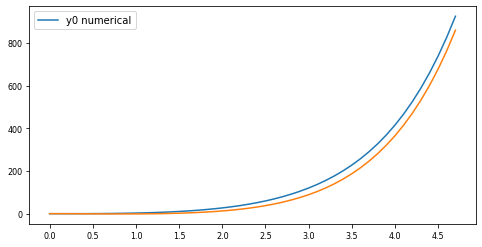

In [ ]:
# Get initial conditions between -1 and 1 uniformly
init_condition = (2 * np.random.random_sample((3,)) - 1)

# Get equation for
x,y1,y2,y0,y3 = symbols('x y1 y2 y0 y3')
terms = create_subterms(y_terms, num_subterms(min_subterms, max_subterms))

# Solve numerically
print("terms are",terms)
print("init condition is ",init_condition)
soln = main_solver(terms,0,10,init_condition)

# Get the point at which it terminated
t_stop = soln[0,soln.shape[1]-1]
print("t_stop is ", t_stop)

# Get the t-step
t_step = soln[0,1]-soln[0,0]
print("T step is ",t_step)

# Graph it!
plt.figure(figsize=(8,4))
plt.plot(soln[0,],soln[1,],label='y0 numerical')
plt.legend()
plt.xticks(np.arange(0, t_stop,step=0.5))
plt.tick_params(axis='both', which='major', labelsize=8)

# Get the dominant balances
x,y1,y2,y0,y3 = symbols('x y1 y2 y0 y3')
absterms, domterms = dom_bal(terms, soln[1:5,:], soln[0,:])

# Get the regimes
regimes = get_regimes(domterms)
print(regimes)

# Iterate through regimes
regime_init = init_condition
regimes_soln = np.zeros(soln.shape[1])
regimes_soln[0] = init_condition[0]
for reg_num in range(1,len(regimes)):
  start_idx = regimes[reg_num][0]
  end_idx = regimes[reg_num][1]
  if start_idx != end_idx:
    start_t = 0.1*start_idx
    end_t = 0.1*end_idx
    winner_0 = int(list(regimes[reg_num][2])[0])
    winner_1 = int(list(regimes[reg_num][2])[1])
    regime_solved = dom_sol([terms[winner_0],terms[winner_1]],a=start_t,b=end_t,y_init=regime_init)
    if len(regime_solved[1,]) != len(regimes_soln[start_idx:end_idx+1]):
      regime_solved = dom_sol([terms[winner_0],terms[winner_1]],a=round(start_t,1),b=round(end_t,1),y_init=regime_init)
    regimes_soln[start_idx:end_idx+1] = regime_solved[1,]
    regime_init = regime_solved[1:,-1]

plt.plot(soln[0,],regimes_soln,label='dominant balances')

In [ ]:
#MRE
round(100*verifier(soln[1,],regimes_soln,0,False),3)

In [ ]:
#Number of regimes
len(regimes)-1